# taq_data_load_V4

#### Juan Camilo Henao Londono - 26.03.2019
#### AG Guhr - Universitaet Duisburg-Essen

This version is the same as the V1, just some small adjusments as it was proved I can not find a better implementation.
I removed the `for loop` in the `data_to_array` function.

#### This implementation is NOT used to obtain the TAQ data

In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
from dask.multiprocessing import get
import pickle
import matplotlib.pyplot as plt
import swifter
%matplotlib inline

In [2]:
def taq_data_extract(ticker, year, month):

    print('Obtaining data from ticker {}'.format(ticker))
    data_quotes = dd.read_csv('../TAQ_{1}/Data/{0}_{1}_NASDAQ_quotes.csv'
                              .format(ticker, year),
                              usecols=range(4),
                              sep=' ',
                              names=['Date', 'Time', 'Bid', 'Ask'],
                              parse_dates=['Date']).set_index('Date')
    data_quotes = data_quotes['{}-{}'.format(year, month)]
    data_quotes = data_quotes.compute()

    data_trades = dd.read_csv('../TAQ_{1}/Data/{0}_{1}_NASDAQ_trades.csv'
                              .format(ticker, year),
                              usecols=range(3),
                              sep=' ',
                              names=['Date', 'Time', 'Ask'],
                              parse_dates=['Date']).set_index('Date')
    data_trades = data_trades['{}-{}'.format(year, month)]
    data_trades = data_trades.compute()
    
    return (data_quotes, data_trades)

In [3]:
def get_sec(time_str):
    h, m, s = time_str.split(':')
    return int(h) * 3600 + int(m) * 60 + int(s)

In [4]:
def data_to_array(quotes, trades, year, month, days):
    
    print('Processing data')
    print()

    data_q = quotes.loc[year + '-' + month + '-' + d].copy()
    data_t = trades.loc[year + '-' + month + '-' + d].copy()

    data_q.loc[:, 'Time'] = data_q['Time'].apply(get_sec)
    data_t.loc[:, 'Time'] = data_t['Time'].apply(get_sec)

    data_q = data_q.loc[(data_q['Time'] >= 34800) & (data_q['Time'] < 57000)]
    data_t = data_t.loc[(data_t['Time'] >= 34800) & (data_t['Time'] < 57000)]

    print('Saving data ' + year + '-' + month + '-' + d)

    print('Quotes')
    time_q = np.array(data_q['Time'])
    bid_q = np.array(data_q['Bid'])
    ask_q = np.array(data_q['Ask'])

    print('Time, bid and ask')
    pickle.dump((time_q, bid_q, ask_q),
                open('../TAQ_{1}/TAQ_py/TAQ_{0}_quotes_{1}{2}{3}.pickle'
                     .format(ticker, year, month, d), 'wb'))
    print('Trades')
    time_t = np.array(data_t['Time'])
    ask_t = np.array(data_t['Ask'])
    time_t, ask_t = zip(*sorted(zip(time_t, ask_t)))
    time_t = np.asarray(time_t)
    ask_t = np.asarray(ask_t)

    print('Time and ask')
    pickle.dump((time_t, ask_t),
                open('../TAQ_{1}/TAQ_py/TAQ_{0}_trades_{1}{2}{3}.pickle'
                     .format(ticker, year, month, d), 'wb'))

    print()
        
    return (time_q, bid_q, ask_q, time_t, ask_t)

In [5]:
def months_days_list():
    days_list = []
    months_list = []

    for i in range(1,32):
        if (i < 10):
            days_list.append('0' + str(i))
        else:
            days_list.append(str(i))

    for i in range(1,13):
        if (i < 10):
            months_list.append('0' + str(i))
        else:
            months_list.append(str(i))

    return(months_list, days_list)

In [6]:
tickers = ['AAPL', 'MSFT']
year = '2008'

print(get_sec('09:40:00'))
print(get_sec('15:50:00'))

months_list, days_list = months_days_list()

for ticker in tickers:
    
    for month in months_list:
                
        om_days = days_list[:]
        
        data_quotes, data_trades = taq_data_extract(ticker, year, month)
            
        for d in days_list:

            try:
                (time_q, bid_q, ask_q, time_t, ask_t) = data_to_array(data_quotes, data_trades, year, month, d)
            except KeyError:
                om_days.remove(d)
                
        pickle.dump(om_days,
                open('days_{}.pickle'
                     .format(month), 'wb'))

34800
57000
Obtaining data from ticker AAPL
CPU times: user 5min 10s, sys: 24.1 s, total: 5min 34s
Wall time: 2min 58s
Processing data

Saving data 2008-01-02
Quotes
Time, bid and ask
Trades
Time and ask

CPU times: user 52.7 s, sys: 1.65 s, total: 54.3 s
Wall time: 54.1 s
CPU times: user 6min 3s, sys: 25.7 s, total: 6min 28s
Wall time: 3min 52s


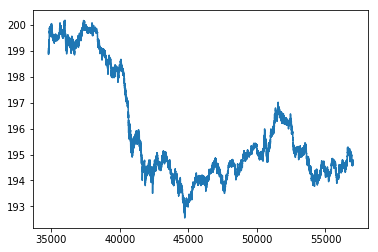

In [7]:
plt.plot(time_q, bid_q)